# __Step 5: Make predictions__

The best model is Word2Vec:
- Because the performance is all very similar, for interpretability purpose, choose to focus on the Word2Vec-based model with ` [min_count, window, n_gram] = [20, 8, 3]`. 
- This way there is a smaller set of eature (because min_count is high) that include tri-grams (so 3 word combinations that help with interpretation).

Goal
- Make predictions of the entire corupus


## ___Set up___

### Module import

In [111]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from pathlib import Path
import script_2_3_text_classify_w2v as script23

### Key variables

In [2]:
# Reproducibility
seed = 20220609

# Setting paths
work_dir   = Path.home() / "projects/plant_sci_hist/2_text_classify"

os.chdir(work_dir)

# Training data for interpretation purpose
corpus_train = work_dir / "corpus_train.json"

# The columns to focus on
target_col = 'txt'

# Trainded Word2Vec model, tokenizer, and vocab for getting embeddings
w2v_name   = work_dir / f"model_cln_w2v_20-8-3"
tok_name   = work_dir / f"model_cln_w2v_token_20-8-3"
vocab_name = work_dir / f"model_cln_w2v_vocab_20-8-3"

# Getting ngrams
ngram = 3
min_count = 20

# DNN checkpoint path
cp_filepath = work_dir / f"model_cln_w2v_20-8-3_dnn"

# Corpus to make predictions for
corpus_dir  = Path.home() / "projects/plant_sci_hist/1_obtaining_corpus"
corpus_file = corpus_dir / "pubmed_qualified.tsv"

## ___Analysis of prediction outcome___

### Load w2v model, tokenizer, and vocab

Need:
- W2V model
- Tokenizer and vocab
- Trained DNN model

In [3]:
# Load word2vec model
with open(w2v_name, "rb") as f:
  model_w2v = pickle.load(f)
model_w2v

In [4]:
# Load tokenzier and vocab
with open(tok_name, "rb") as f:
  tokenizer = pickle.load(f)

with open(vocab_name, "rb") as f:
  vocab = pickle.load(f)

### Get training/testing data

In [5]:
# Not needed...
with corpus_train.open("r+") as f:
  corpus_combo_json = json.load(f)

## __Make predictions on the whole dataset__

### Read corpus that needs to be predicted

In [6]:
corpus_df_raw = pd.read_csv(corpus_file, delimiter='\t')

In [7]:
corpus_df_raw.shape

(1497511, 6)

In [183]:
# Drop duplicated rows
corpus_df = corpus_df_raw[corpus_df_raw.duplicated() == False]

# Rid of all records with NAs
corpus_df = corpus_df.dropna(axis=0)

# Create a new column 'txt' which is concatenated between 'Title' and 'Abstract'
corpus_df['txt'] = corpus_df['Title'] + " " + corpus_df['Abstract']
corpus_df.shape

(1385417, 7)

In [184]:
# Remove corrections and erratum
corpus_df_titles     = corpus_df['Title']
#corpus_df_titles_idx = corpus_df_titles.index
corpus_df_titles_val = corpus_df_titles.values

# Check for title with issues
remove_tokens = ["correction to:", "correction:",  
                 "erratum", "erratum:",
                 "withdrawn", "withdrawn:"]

reg_article_flags = [] # a list of true (should remain) or false (remove)
count_corrections = 0
for title in corpus_df_titles_val:
  reg_article_flag = 1
  title_lower = title.lower()
  for remove_token in remove_tokens:
    if title_lower.find(remove_token) != -1:
      # Only remove this if 
      title_tokens = title_lower.split(" ")
      if remove_token == title_tokens[0] or \
         (len(title_tokens) > 1 and remove_token == title_tokens[1]):
        #print(title)
        reg_article_flag = 0
        count_corrections +=1
        break
  reg_article_flags.append(reg_article_flag)

print("Correction/erratum/withdrawn:", count_corrections)

Correction/erratum/withdrawn: 699


In [185]:
corpus_df["reg_article"] = reg_article_flags
(corpus_df["reg_article"] == 0).value_counts()

False    1384718
True         699
Name: reg_article, dtype: int64

In [187]:
corpus_df = corpus_df[corpus_df["reg_article"] == 1]
corpus_df.shape

(1384718, 8)

In [9]:
corpus_df.head(3)

,PMID,Date,Journal,Title,Abstract,QualifiedName,txt
0,36,1975-11-01,The British journal of nutrition,The effects of processing of barley-based supp...,1. In one experiment the effect on rumen pH of...,barley,The effects of processing of barley-based supp...
1,52,1975-12-02,Biochemistry,Evidence of the involvement of a 50S ribosomal...,The functional role of the Bacillus stearother...,rose,Evidence of the involvement of a 50S ribosomal...
2,60,1975-12-11,Biochimica et biophysica acta,The reaction between the superoxide anion radi...,1. The superoxide anion radical (O2-) reacts w...,tuna,The reaction between the superoxide anion radi...


In [10]:
corpus_df['txt'][0][:100]

'The effects of processing of barley-based supplements on rumen pH, rate of digestion of voluntary in'

### Get word embeddings, w2v feature matrix using corpus

In [188]:
# Specify the input corpus
X = corpus_df[target_col]

# Get ngrams: 
# ##### This is not necessary #####
#X_ngrams = script23.get_ngram(X, ngram, min_count, "train", work_dir=work_dir)

In [189]:
# Get embeddings: ~4 min
embeddings, X_w2v = script23.get_embeddings(X, model_w2v, tokenizer, vocab)

In [190]:
embeddings.shape, X_w2v.shape

((398412, 300), (1384718, 500))

In [191]:
X_w2v[0][:20]

array([    1,     1,     1,   856,     1,   631,    65,     1,     1,
       22713,   493,    43,     1,  3786,     1,  8018,  1214,     1,
        4962,  1222], dtype=int32)

### Load model

In [192]:
model_emb = tf.keras.models.load_model(cp_filepath)


### Make predictions 

In [193]:
# This takes a long time so save the prediction and prediction prob to a file
# ~52 min
y_pred_prob   = model_emb.predict(X_w2v)
dic_y_mapping = {n:label for n,label in enumerate(np.unique([0,1]))}
y_pred        = [dic_y_mapping[np.argmax(pred)] for pred in y_pred_prob]

In [19]:
len(y_pred)

1385417

In [20]:
corpus_df["y_prob"] = y_pred_prob[:,1]
corpus_df["y_pred"] = y_pred
corpus_df.shape

(1385417, 9)

In [21]:
corpus_df['y_pred'].value_counts()

0    963677
1    421740
Name: y_pred, dtype: int64

In [22]:
#Save prediction file
corpus_df_file = work_dir / "pubmed_qual_1385417_w2v_pred_prob.tsv.gz"
corpus_df.to_csv(corpus_df_file, sep='\t', compression='gzip')

In [23]:
### Consolidate positive predictions into a compressed dataframe
corpus_df_pos_file = work_dir / "corpus_plant_421740.gz"
corpus_df[corpus_df['y_pred'] == 1].to_csv(corpus_df_pos_file, sep='\t', 
                                                            compression='gzip')

### Plot probability distribution

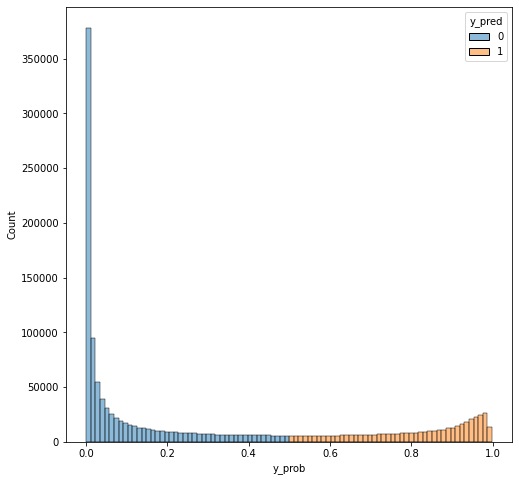

In [29]:
plt.figure(figsize=(8,8))
sns.histplot(data=corpus_df, x="y_prob", hue="y_pred")
plt.savefig(work_dir / 'figure_pubmed_qual_1385417_w2v_pred_prob.pdf')

## __Check recovery of articles from other plant science journals__

### Select journals and get tpr

- Plant science journals with >2,000 retrieved pubmed records were used for training.
- There are many other plant science journals not covered, particularly those not in molecular plant science, include:
  - Current opinion in plant biology,1806
  - Trends in plant science,1723
  - Functional plant biology : FPB,1717
  - Molecular plant pathology,1573
  - Molecular plant,1141
  - Journal of integrative plant biology,1092
  - Journal of plant research,1032
  - Physiology and molecular biology of plants : an international journal of functional plant biology,830
  - Nature plants,538
  - The plant pathology journal,443
  - Annual review of plant biology,417
  - The plant genome,321

In [137]:
# positive journals not used for training
j_positive_nt = [
  'Current opinion in plant biology',
  'Trends in plant science',
  'Functional plant biology : FPB',
  'Molecular plant pathology',
  'Molecular plant',
  'Journal of integrative plant biology',
  'Journal of plant research',
  'Physiology and molecular biology of plants : an international journal of '+\
    'functional plant biology',
  'Nature plants',
  'The plant pathology journal',
  'Annual review of plant biology',
  'The plant genome']

In [138]:
corpus_df.head(2)

,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,y_prob,y_pred
0,36,1975-11-01,The British journal of nutrition,The effects of processing of barley-based supp...,1. In one experiment the effect on rumen pH of...,barley,The effects of processing of barley-based supp...,0.162140,0
1,52,1975-12-02,Biochemistry,Evidence of the involvement of a 50S ribosomal...,The functional role of the Bacillus stearother...,rose,Evidence of the involvement of a 50S ribosomal...,0.286834,0


In [139]:
def get_tpr(corpus_df, j_to_check, ptype):
  '''Plot prediciton probabilities of each journal
  Args
    df: dataframe with journal names, predictions
    journal: name of journal in pubmed format
    ptype: positive journal type, used for training or not
  Outputs:
    pdf: prediction probability histogram colored based on predicted classes
  '''
  # Count the predictions
  j_to_check_list = []
  for i in j_to_check:
    j_df    = corpus_df[corpus_df['Journal'] == i]     # entries of a journal
    i_count = j_df['y_pred'].value_counts()            # counts of y_pred, series
    j_to_check_list.append(i_count)

  print("Put the series into dataframe")
  j_to_check_df = pd.concat(j_to_check_list, axis=1)
  j_to_check_df.columns = j_to_check
  j_to_check_df = j_to_check_df.transpose()
  print(j_to_check_df.head(2))
  print(j_to_check_df[1].shape[0])

  print("Add tpr column")
  tpr = []
  for i in range(j_to_check_df[1].shape[0]):
    tp = j_to_check_df[1].iloc[i]
    fn = j_to_check_df[0].iloc[i]
    tpr.append(tp/(tp+fn))
  j_to_check_df['tpr'] = tpr

  print("Draw and save bar plot")
  sns.barplot(data=j_to_check_df, x='tpr', y=j_to_check_df.index)

  # Prevent trucated text
  # https://stackoverflow.com/questions/45239261/matplotlib-savefig-text-chopped-off
  plt.savefig(
    work_dir / f'figure_pubmed_w2v_pred_prob_{ptype}_journal_check_fdr.pdf',
    bbox_inches = "tight")

  return j_to_check_df

Put the series into dataframe
                                     1    0
Current opinion in plant biology  1636  170
Trends in plant science           1450  273
12
Add tpr column
Draw and save bar plot


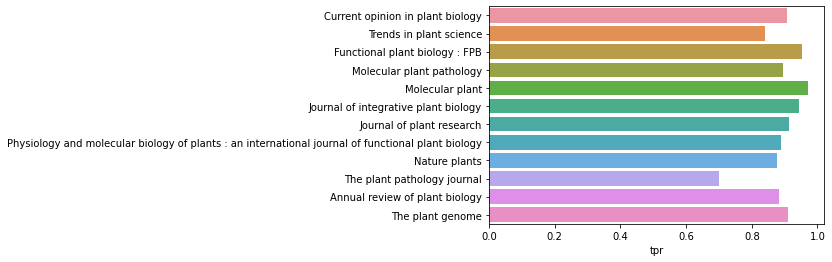

In [153]:
j_positive_nt_df = get_tpr(corpus_df, j_positive_more, "not-training")

In [150]:
def plot_pdf(df, df_tpr, journal, ptype):
  '''Plot prediciton probabilities of each journal
  Args
    df: dataframe with citations as rows, with columns containing journal names,
      predictions, prediction probabilities, among others
    df_tpr: dataframe with journals as index and a column with tpr values
    journal: name of journal in pubmed format
    ptype: positive journal type, used for training or not
  Outputs:
    pdf: prediction probability histogram colored based on predicted classes
  '''
  df_j   = df[df['Journal'] == journal]
  j_name = "-".join(journal.split(":")[0].strip().split(" "))
  tpr    = round(df_tpr['tpr'].loc[journal], 2) 

  plt.figure(figsize=(4,4))
  sns.histplot(data=df_j, x="y_prob", hue="y_pred", bins=100)
  plt.title(j_name)
  plt.text(0.1, 20, "tpr=" + str(tpr))
  plt.savefig(work_dir / f'figure_pubmed_w2v_pred_prob_{ptype}_{j_name}.pdf')

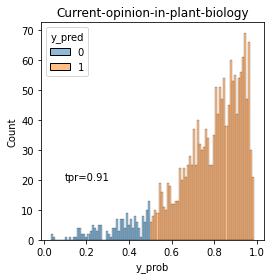

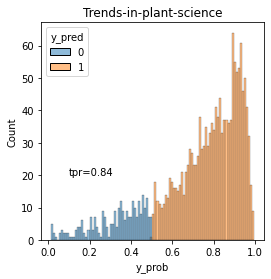

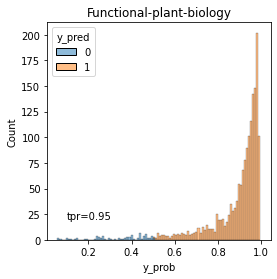

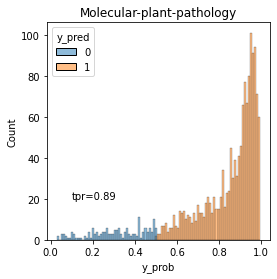

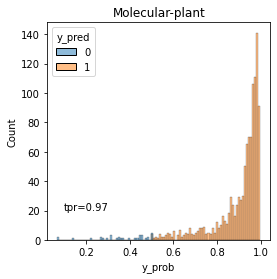

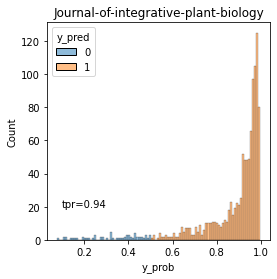

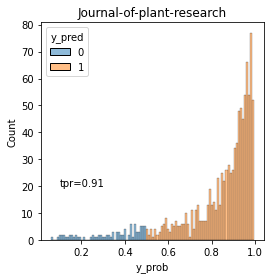

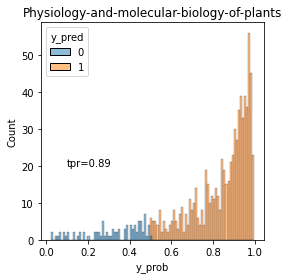

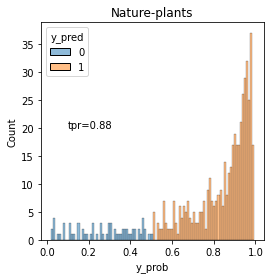

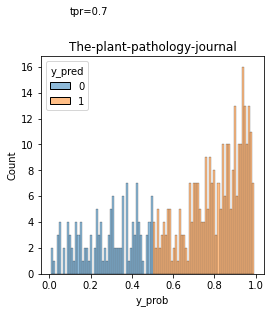

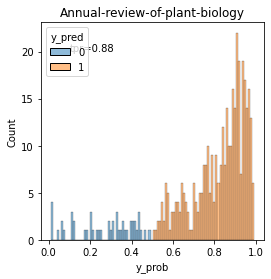

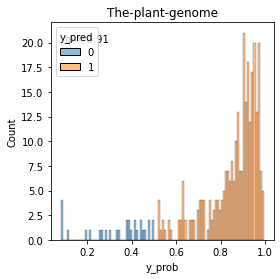

In [151]:
for journal in j_positive_more:
  plot_pdf(corpus_df, j_positive_nt_df, journal, "not-training")

### Also check the positive journals used for training for comparison

In [147]:
# positive journal used for training
j_pos_t = ['Plant physiology', 'Frontiers in plant science', 'Planta',
             'The Plant journal : for cell and molecular biology', 
             'Journal of experimental botany', 'Plant molecular biology',
             'The New phytologist', 'The Plant cell', 'Phytochemistry',
             'Plant &amp; cell physiology', 'American journal of botany',
             'Annals of botany', 'BMC plant biology', 'Tree physiology',
             'Molecular plant-microbe interactions : MPMI',
             'Plant biology (Stuttgart, Germany)', 
             'Plant biotechnology journal']

Put the series into dataframe
                                1     0
Plant physiology            20584   652
Frontiers in plant science   9883  1145
17
Add tpr column
Draw and save bar plot


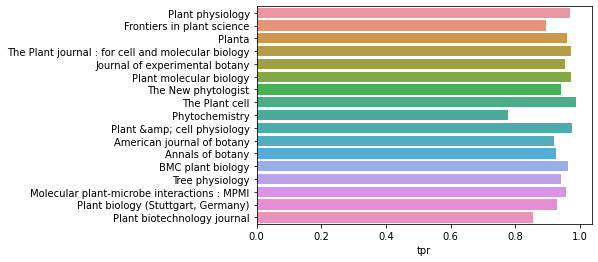

In [148]:
j_positive_t_df = get_tpr(corpus_df, j_pos_t, "not-training")

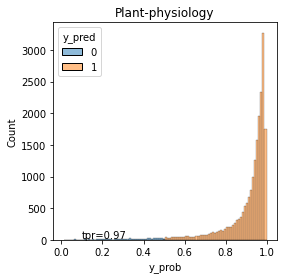

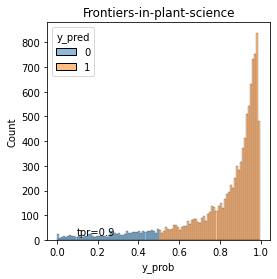

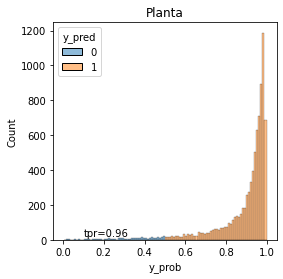

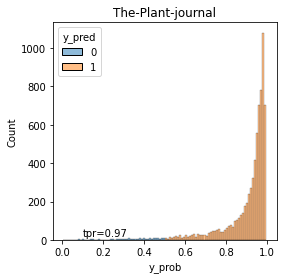

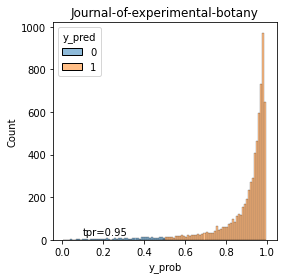

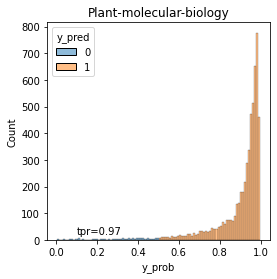

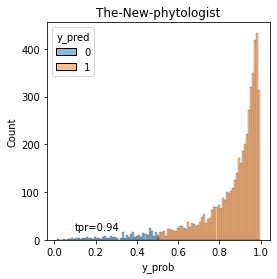

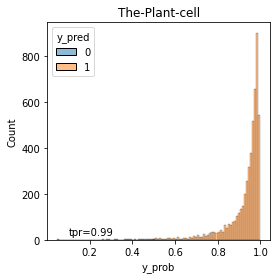

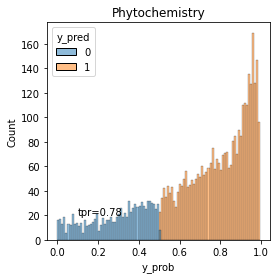

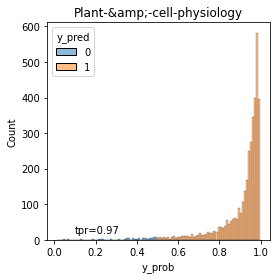

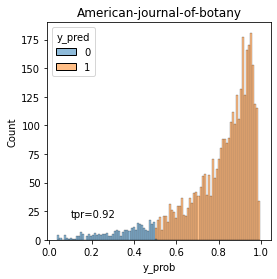

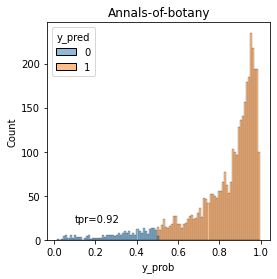

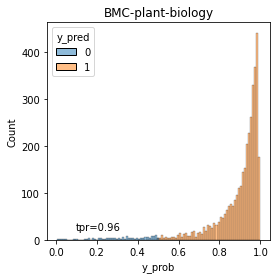

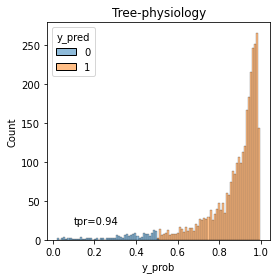

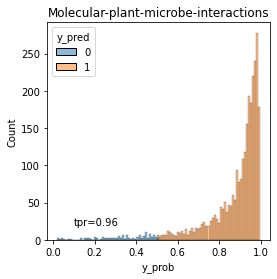

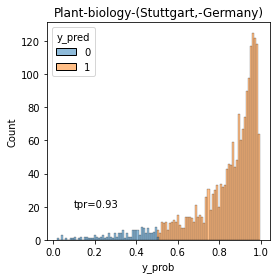

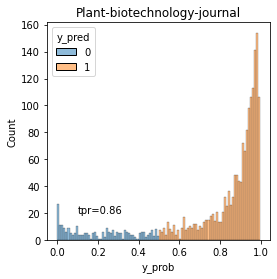

In [154]:
for journal in j_pos_t:
  plot_pdf(corpus_df, j_positive_t_df, journal, "training")

### Look into Nature Plants

In [158]:
corpus_df_nat_pln = corpus_df[corpus_df["Journal"] == "Nature plants"]
corpus_df_nat_pln.shape

(538, 9)

In [160]:
corpus_df_nat_pln_file = work_dir / 'corpus_df_nat_pln.tsv'
corpus_df_nat_pln.to_csv(corpus_df_nat_pln_file, sep='\t')

### Identify articles that are corrections

